# Plot global DTA tree 


This notebook contains code for producing the full global tree, generated by running genomes from countries with >5 genomes though Beast 1.8 with a skyline population size prior, and inferring migration history with asymmetric DTA with BSSVA for all 15 countries. This script was adapted from [Louise Moncla's Mumps phylo work](https://github.com/blab/mumps-wa-phylodynamics)and from [Gytis Dudas'ebola work](https://github.com/ebov/space-time)

In [2]:
import baltic as bt
import pandas as pd
import arviz as az

from datetime import datetime as dt
from datetime import timedelta
import time
from io import StringIO
import altair as alt
from zipfile import ZipFile
import math


import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp
from scipy.stats import gaussian_kde
import geopandas

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
from scipy.special import binom

In [3]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [4]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [5]:
# set path to tree to load 
#tree_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_country_mcc.tree"
#tree_path = "/Users/mparedes/Desktop/test_skygrid_mcc.tree"
tree_path = "/Users/mparedes/Desktop/mpox_rhino/1000_prev_sub_region_dta_mcc.tree"

In [5]:
# load trees
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2023.0068)

In [6]:
tree.treeStats()


Tree height: 0.777391
Tree length: 145.719871
strictly bifurcating tree
annotations present

Numbers of objects in tree: 2005 (1002 nodes and 1003 leaves)



In [7]:
all_geos = []

for k in tree.Objects: 
    if k.branchType=='node':
        #print(k.traits)
        division = k.traits['country']
        all_geos.append(division)
print(set(all_geos))

KeyError: 'country'

In [6]:
def parse_tree(tree, traitType):
    # add together probabilities for divisions in the same regions

    # parse leaf and node information into a dictionary for plotting
    metadata = {}
    node_types = {}
    node_probs = {}

    for k in tree.Objects: ## iterate over objects in tree
        if k.branchType=='leaf':
            division = k.traits[traitType]
            #region = regions[division]
            metadata[k] = {}
            metadata[k]["division"] = division
            #metadata[k]["region"] = region
            node_probs[k] = k.traits[traitType + ".prob"]  # for a leaf, this is always 1.0

        # parse the nodes now and pick out the type trait
        if k.branchType=='node':
            node_division = k.traits[traitType]
            division_prob = k.traits[traitType + ".prob"]

            #node_region = regions[node_division]       
            geo_set = k.traits[traitType + '.set']
            geo_set_prob = k.traits[traitType + '.set.prob']

            node_prob = 0
            for i in range(len(geo_set)):
                division = geo_set[i]
                #region = regions[division]
                geo_prob = geo_set_prob[i]

                #if region == node_region:
                node_prob += geo_prob


            node_types[k] = {}
            node_types[k]["division"] = node_division
            #node_types[k]["region"] = node_region 
            node_probs[k] = division_prob
            #division_probs[k] = division_prob
            #print(node_probs[k])
    return(node_probs, node_types)

In [9]:
parse_tree(tree, "country")

KeyError: 'country'

In [10]:


#region = {('Canada','USA'):'North America',
#          'Finland':'Northern Europe',
#          ('Austria','Germany','Switzerland','UnitedKingdom','France','Belgium','Netherlands'):'Western Europe', 
#          ('Slovakia','Slovenia'):'Central/Eastern Europe',
#          ('Italy','Portugal','Spain'):'Southern Europe',
#          ('Colombia','Peru'):'South America'}




         # blues
colors = {"Canada":"#133253",
          "USA":"#2664A5",
        
          
          # greens
          "UnitedKingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }

uncertainty_color = "#B9B9B9"

In [11]:
division_order = ["Canada",
"USA",
"UnitedKingdom",
"Germany",
"Switzerland",
"Austria",
"France",
"Belgium",
#"Netherlands",
"Slovakia",
"Slovenia",
"Italy",
"Portugal",
"Spain",
"Colombia",
"Peru"
#"Finland"
                
] 

In [971]:
# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}
pos_support = []

for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['country']
        metadata[k] = {}
        metadata[k]["division"] = division
        node_probs[k] = k.traits["country.prob"]
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["country"]
        node_types[k] = {}
        node_types[k]["division"] = node_division
        node_probs[k] = k.traits["country.prob"]
        pos_support.append(k.traits["posterior"])

<generator object <genexpr> at 0x7ff0f37aea50>
<generator object <genexpr> at 0x7ff0f37aea50>
[2022.11939782 2022.23553499]


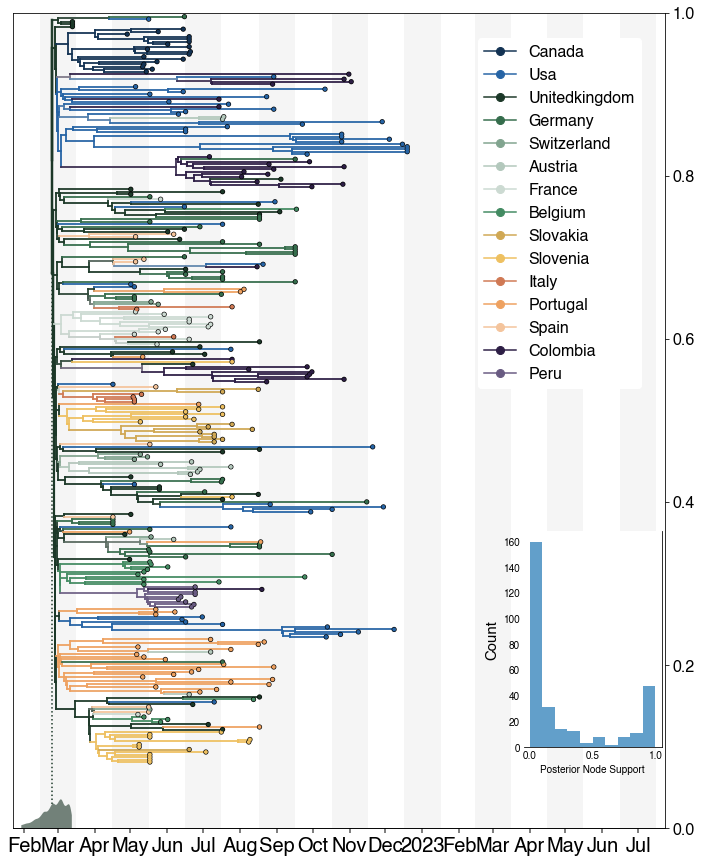

In [985]:
root_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_country_masked_skygrid.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))

print (np.mean(x) for x in rootHeights.values())
print (np.median(x) for x in rootHeights.values())

print(az.hdi(np.array(rootHeights['age(root)']), 0.95))

fig,ax = plt.subplots(figsize=(12,15),facecolor='w')
ax2 = ax.twinx()


branchWidth=1.75 ## default branch width
tipSize = 15

#effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Stroke(linewidth=0.5, foreground='k')]
offsetTree=25
# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y + offsetTree
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y+offsetTree,k.children[0].y+offsetTree],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
 #   ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98)

ax2 = ax.twinx()
for intro in rootHeights.keys():
    if intro=='age(root)':

        hpdLo,hpdHi=az.hdi(np.array(rootHeights['age(root)']), 0.95)

        x_grid=np.linspace(hpdLo,hpdHi,100)
        kde=gaussian_kde(rootHeights['age(root)'])
        y_grid=kde.evaluate(x_grid)

        root_y=[(y*0.8)-1 for y in y_grid]


        c='#1C3828'
            #intro='reservoir'



        topX,topY=tree.Objects[0].absoluteTime,tree.Objects[0].children[0].y+offsetTree

        bottomX=topX
        bottomY=(kde.evaluate(bottomX)*0.8)-1

        ax.plot([bottomX,topX],[bottomY,topY],ls=':',color=c)

        ax.fill_between(x_grid,root_y,y2=-1,facecolor= "#1C3828",edgecolor='none',alpha=0.6)
        #ax.plot(x_grid,root_y,lw=2,color=c,ls='-')
    
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in division_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

    
ax3 = fig.add_axes([0.716, 0.2, 0.16, 0.2])
ax3.hist(pos_support, alpha = 0.7)
#ax.hist(pos_support, 50, density=True, facecolor='g', alpha=0.75)    
ax3.spines['left'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False) 
ax3.set_xlabel("Posterior Node Support", size=10)
ax3.set_ylabel("Count", size=15)
ax3.tick_params(axis='x',labelsize=10,size=0)    

ax3.tick_params(axis='y',labelsize=10,size=0)    


    
xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-1,(len(tree.Objects)+1)/2.0+offsetTree+1)
ax.set_xlim(2022.1,2023.6)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.70, 0.53], loc=3,prop={'size': 16}, facecolor='w')

#fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig('../figures/mcc_dta_country_300.png',dpi=300,bbox_inches='tight')

plt.show()

In [973]:
key_order = {"Canada":1,
"USA":2,
"UnitedKingdom":3,
"Germany":4,
"Switzerland":5,
"Austria":6,
"France":7,
"Belgium":8,
#"Netherlands",
"Slovakia":9,
"Slovenia":10,
"Italy":11,
"Portugal":12,
"Spain":13,
"Colombia":14,
"Peru":15
#"Finland"
                
                 }

In [7]:
def enumerate_subtrees(tree, locTrait):
    
    traitName=locTrait

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees={division:[] for division in division_order}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        kc=kloc     
        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees[kloc].append((kploc,subtree))
    
    return(subtype_trees)

In [975]:
def plot_exploded_tree_no_cases(subtype_trees2, filename, width, height):
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    traitName='country'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=150


    


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        starting_y = cumulative_y
        cumulative_y+=10
        for subtree in subtype_trees[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

            """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
            for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
            for k in loc_tree.Objects:

                xp= k.parent.absoluteTime
                x = k.absoluteTime
                y = k.y + cumulative_y
                c = colors[k.traits[traitName]]
                s = tipSize
                a = k.traits["country.prob"]

                if k.branchType == "leaf":
                    ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                    ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)

                elif k.branchType == "node": 
                    # this plots the vertical lines connecting children and parents on tree
                    ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
                    if k.traits['posterior']>=0.5:
                        ax1.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
               # if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
        
                ax1.plot([xp, x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
#                     else:
#                         ax1.plot([x,cutoff],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
                
                        
                        
                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""
            # first, plot the origin circle
       # first, plot the origin circle
            oriC = colors[origin]

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            if loc_tree.root.parent.traits['posterior']>=0.5:
                ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=2,zorder=200) ## add big circle at base of tree to indicate origin
            else:
                ax1.scatter(oriX,oriY,s=origin_size*0.5,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin


#             #plot dotted line connecting circle to tree 
#             if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
#                 ax1.plot([oriX, min_node_x],[oriY,oriY], ":", color=c,lw=branchWidth,zorder=98)

#             elif oriX < cutoff: # partly before 2016, partial dotteds
#                 ax1.plot([cutoff, min_node_x],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
#                 ax1.plot([cutoff,oriX],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)

#             else:
 #           ax1.plot([oriX, min_node_x],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)
            
            cumulative_y+=loc_tree.ySpan+8 
        oriC = colors[i]
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=oriC, alpha = 0.2)
        

    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2022.1,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [976]:
exploded_tree_output_file_name2 = "../figures/test.png"




In [977]:
subtype_trees2 = enumerate_subtrees(tree, "country")


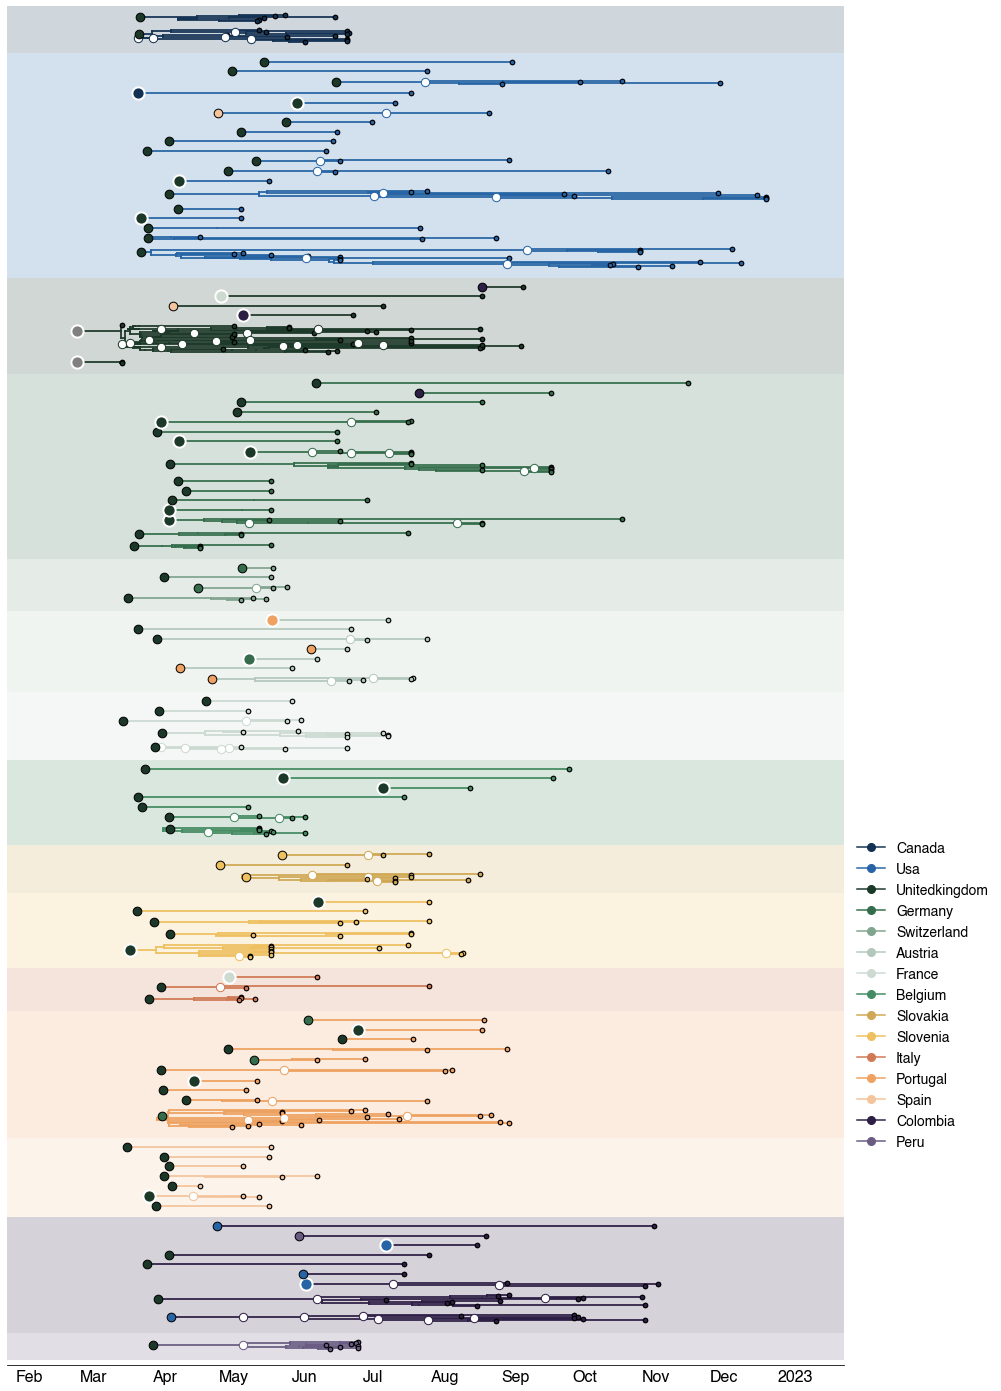

In [978]:
plot_exploded_tree_no_cases(subtype_trees2, exploded_tree_output_file_name2,15,25)  # dotted lines, no case counts


In [979]:
def foo_plot_exploded_tree(subtype_trees2, filename, width, height):
    
    raw_cases = pd.read_csv("../case-rt-analysis/data/monkeypox-cases-counts.tsv", sep="\t")
    raw_cases.location[raw_cases["location"] == "United States"] = "USA"
    raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"
    raw_cases.date = raw_cases.date.astype('datetime64[ns]')
    weekly_data = raw_cases.groupby("location").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["location","date"])    
    weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )

    
    heights={division:[] for division in division_order}

    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')
    #ax2 = ax1.twinx()

    traitName='country'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=100
    cum_bar = 0


    


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        starting_y = cumulative_y
        cumulative_y+=10
        for subtree in subtype_trees[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

            """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
            for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
            for k in loc_tree.Objects:

                xp= k.parent.absoluteTime
                x = k.absoluteTime
                y = k.y + cumulative_y
                c = colors[k.traits[traitName]]
                s = tipSize
                a = k.traits["country.prob"]

                if k.branchType == "leaf":
                    ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                    ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)

                elif k.branchType == "node": 
                    # this plots the vertical lines connecting children and parents on tree
                    ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
                    
                ax1.plot([xp, x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
                
                        
                        
                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""
            # first, plot the origin circle
            oriC = colors[origin]

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            if loc_tree.root.parent.traits['posterior']>=0.5:
                ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=2,zorder=200) ## add big circle at base of tree to indicate origin
            else:
                ax1.scatter(oriX,oriY,s=origin_size*0.5,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin

            #ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
            
            cumulative_y+=loc_tree.ySpan+8 
        oriC = colors[i]
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=oriC, alpha = 0.15)
        heights[i].append((starting_y, ending_y))

    #overlay country cases    
    for i in reversed(sorted(subtype_trees.keys(), key=lambda x:key_order[x])):
        start = heights[i][0][0]
        end = heights[i][0][1]
        x = weekly_data.loc[weekly_data['location'] == i, "d_date"]
        cases = weekly_data.loc[weekly_data['location'] == i, "cases"]
        
           
        test = ((cases- (min(cases)))/(max(cases)-min(cases)))
        y1 = (((cases- (min(cases)))/(max(cases)-min(cases))) *(end- start))
        testprop= ((end-start)/cumulative_y)

        ax1.bar(x, (y1), color=colors[i], width = 0.01,  alpha = 0.3, bottom = start)
            #ax1.xaxis_date()
    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2022.1,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99720/4150676108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United States"] = "USA"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99720/4150676108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"


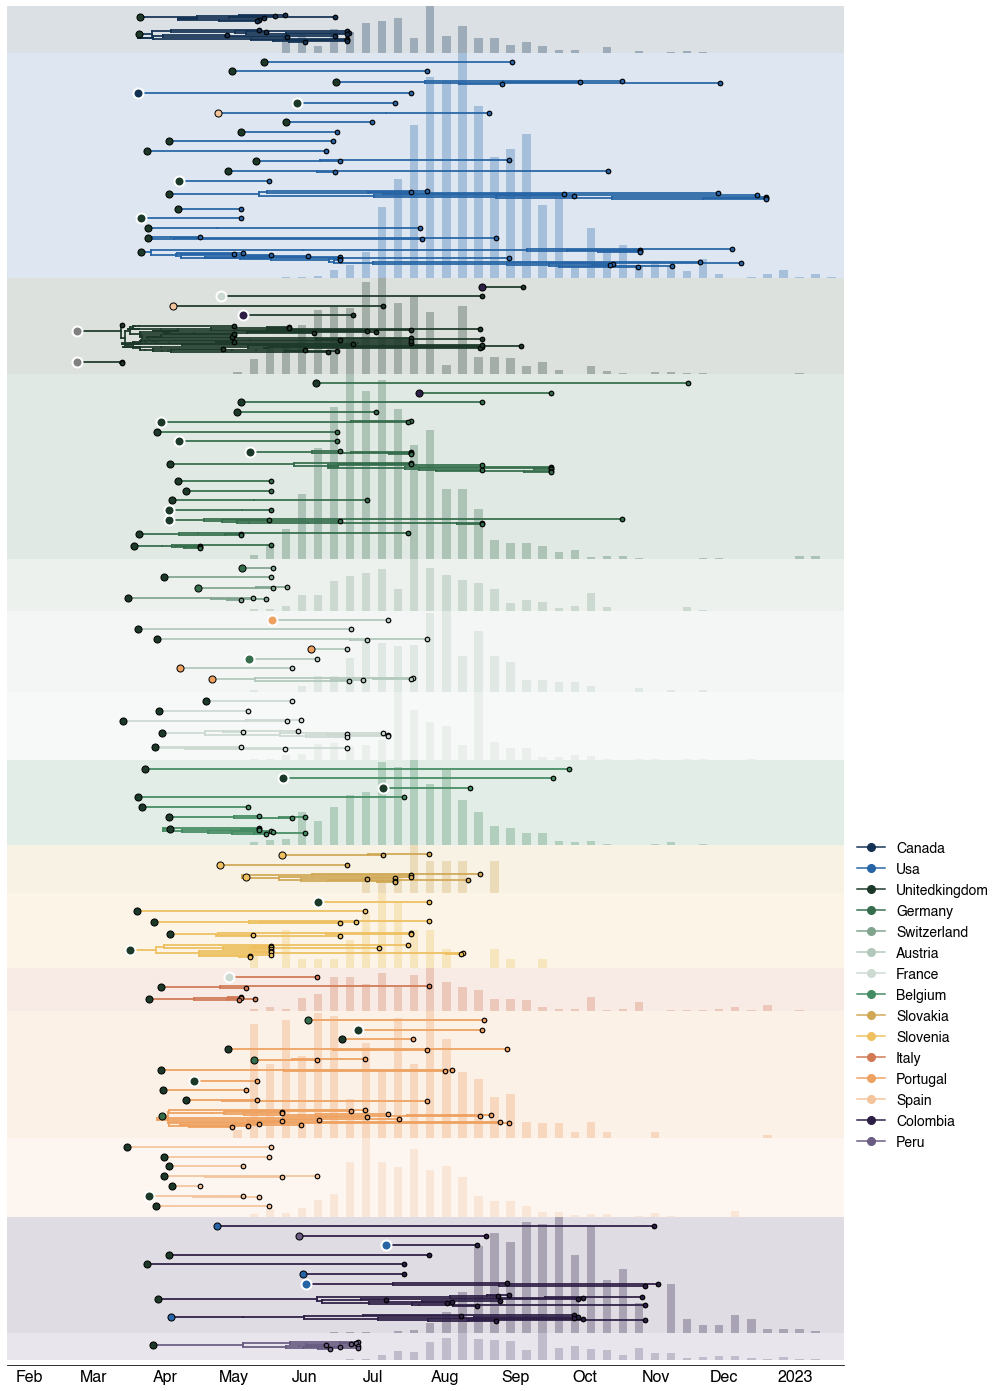

In [980]:
exploded_tree_output_file_name3 = "../figures/country_dta_exploded_tree_with_cases.png"
foo_plot_exploded_tree(subtype_trees2, exploded_tree_output_file_name3,15,25)  # dotted lines, no case counts


In [12]:
## working on DTA tree for regions



In [47]:

colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }
uncertainty_color = "#B9B9B9"
division_order = [ 'NorthAmerica', "WesternEurope", 'CentralEurope', "SouthernEurope", 'SouthAmerica' ]
new_order = [ 'NorthAmerica', "WesternEurope",  "SouthernEurope", 'SouthAmerica' ]

In [48]:
tree_path = "/Users/mparedes/Desktop/mpox_rhino/1000_prev_sub_region_dta_mcc.tree"
# load trees
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2023.0068)

In [49]:
# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}
pos_support = []

for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['region']
        metadata[k] = {}
        metadata[k]["division"] = division
        node_probs[k] = k.traits["region.prob"]
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["region"]
        node_types[k] = {}
        node_types[k]["division"] = node_division
        node_probs[k] = k.traits["region.prob"]
        pos_support.append(k.traits["posterior"])

[2022.1858644 2022.2356158]
[2022.23119902 2022.23561496]
2022.2094897367635


/Users/mparedes/opt/miniconda3/envs/nextstrain/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


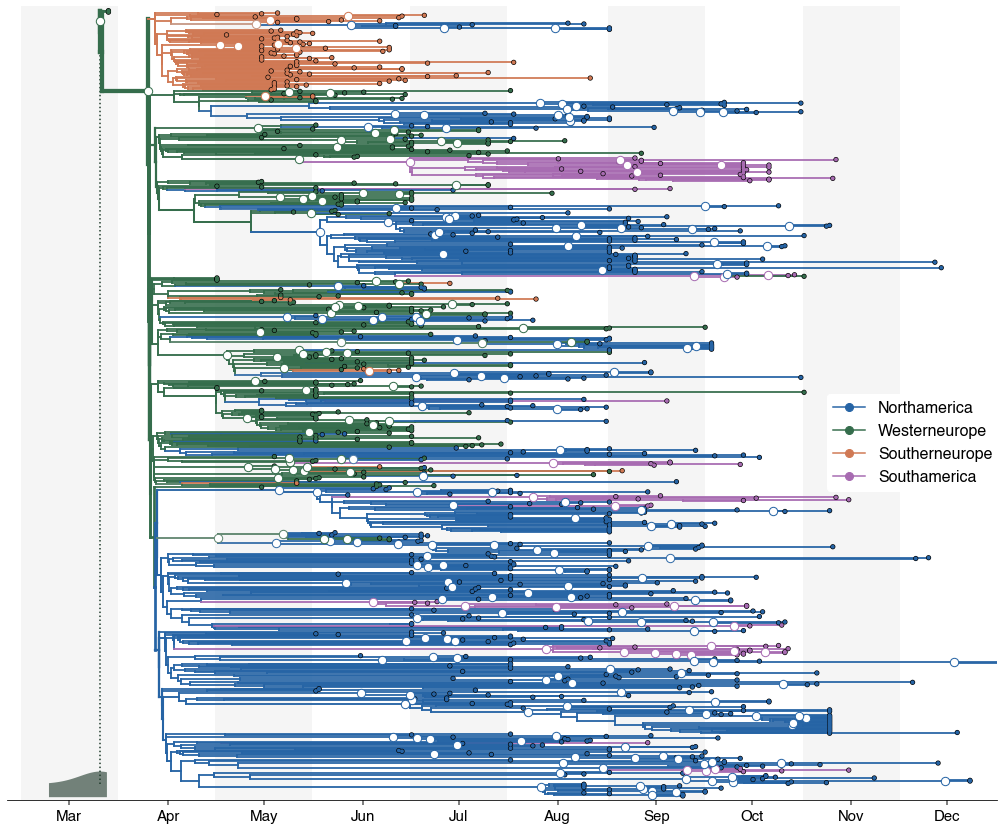

In [50]:
root_path = "/Users/mparedes/Desktop/mpox_rhino/fixed_region_pre_sub_1000_masked.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))


print(az.hdi(np.array(rootHeights['age(root)']), 0.95))
print(az.hdi(np.array(rootHeights['age(root)']), 0.5))
print(np.mean(np.array(rootHeights['age(root)'])))



fig,ax = plt.subplots(figsize=(16,12),facecolor='w')



branchWidth=1.75 ## default branch width
tipSize = 15

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y 
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        if k.traits['posterior']>=0.5:
            ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
    
for intro in rootHeights.keys():
    if intro=='age(root)':

        hpdLo,hpdHi=az.hdi(np.array(rootHeights['age(root)']), 0.95)

        x_grid=np.linspace(hpdLo,hpdHi,100)
        kde=gaussian_kde(rootHeights['age(root)'])
        y_grid=kde.evaluate(x_grid)+20

        root_y=[(y*0.8)-1 for y in y_grid]


        c='#1C3828'
            #intro='reservoir'



        topX,topY=tree.Objects[0].absoluteTime,tree.Objects[0].children[0].y

        bottomX=topX
        bottomY=(kde.evaluate(bottomX)*0.8)-1

        ax.plot([bottomX,topX],[bottomY,topY],ls=':',color=c)

        ax.fill_between(x_grid,root_y,y2=-1,facecolor= "#1C3828",edgecolor='none',alpha=0.6)
        #ax.plot(x_grid,root_y,lw=2,color=c,ls='-')
        
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in new_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

# ax3 = fig.add_axes([0.68, 0.75, 0.16, 0.2])
# ax3.hist(pos_support, alpha = 0.7)
# #ax.hist(pos_support, 50, density=True, facecolor='g', alpha=0.75)    
# ax3.spines['left'].set_visible(False)
# #ax.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False) 
# ax3.set_xlabel("Posterior Node Support", size=10)
# ax3.set_ylabel("Count", size=10)
# ax3.tick_params(axis='x',labelsize=10,size=0)    
# ax3.tick_params(axis='y',labelsize=10,size=0)    

xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(2022.15,2023)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=15,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.82, 0.38], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig('../figures/mcc_dta_550_skygrid.png',dpi=300,bbox_inches='tight')

plt.show()

In [32]:
convertDate(str(2022.2267778003936),'%Y','%Y-%m-%d')

ValueError: unconverted data remains: .2267778003936

In [16]:
region = {'Canada':'NorthAmerica',
          'United States':'NorthAmerica',
         'Finland':'NorthernEurope',
           'Austria': 'WesternEurope',
        'Germany':'WesternEurope', 
        'Switzerland':'WesternEurope',
         'United Kingdom':'WesternEurope',
        'France':'WesternEurope',
        'Belgium':'WesternEurope',
        'Netherlands':'WesternEurope',
        'Slovakia':'CentralEurope',
        'Slovenia':'CentralEurope',
        'Italy':'SouthernEurope',
        'Portugal':'SouthernEurope',
        'Spain':'SouthernEurope',
         'Colombia':'SouthAmerica',
          
        'Peru':'SouthAmerica'}


key_order = {"NorthAmerica":1,
"WesternEurope":2,
"CentralEurope":3,
"SouthernEurope":4,
"SouthAmerica":5,

                
                 }

In [17]:
def enumerate_subtrees(tree):
    
    traitName="region"

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees={division:[] for division in division_order}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        kc=kloc     
        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees[kloc].append((kploc,subtree))
    
    return(subtype_trees)

In [18]:
subtype_trees2 = enumerate_subtrees(tree)


In [19]:
def foo_plot_exploded_tree_with_cases(subtype_trees2, filename, width, height, division_level):
    
    raw_cases = pd.read_csv("../case-rt-analysis/data/monkeypox-cases-counts.tsv", sep="\t")
    #print(raw_cases[raw_cases.location =="United Kingdom"])
    raw_cases.location[raw_cases["location"] == "United States"] = "USA"
    raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"
    #print(raw_cases.location.value_counts())
    raw_cases["region"] = np.nan
    raw_cases.region = raw_cases.location.map(region)
    raw_cases.date = raw_cases.date.astype('datetime64[ns]')
    #print(raw_cases.location.value_counts())

    if division_level == "region":
        raw_cases = raw_cases.dropna()

        weekly_data = raw_cases.groupby("region").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["region","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
    elif division_level =="country":
        weekly_data = raw_cases.groupby("location").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["location","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
        
            
    heights={division:[] for division in division_order}

    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')
    #ax2 = ax1.twinx()

    traitName='region'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=100
    cum_bar = 0


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        starting_y = cumulative_y
        cumulative_y+=10
        for subtree in subtype_trees2[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

            """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
            for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
            for k in loc_tree.Objects:

                xp= k.parent.absoluteTime
                x = k.absoluteTime
                y = k.y + cumulative_y
                c = colors[k.traits[traitName]]
                s = tipSize
                a = k.traits["region.prob"]

                if k.branchType == "leaf":
                    ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                    ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)

                elif k.branchType == "node": 
                    # this plots the vertical lines connecting children and parents on tree
                    ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
                    if k.traits['posterior']>=0.5:
                        ax1.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
                ax1.plot([xp, x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
                
                        
                        
                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""
            # first, plot the origin circle
            oriC = colors[origin]

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            if loc_tree.root.parent.traits['posterior']>=0.5:
                ax1.scatter(oriX,oriY,s=origin_size*2,facecolor=oriC,edgecolor='w',lw=2,zorder=200) ## add big circle at base of tree to indicate origin
            else:
                ax1.scatter(oriX,oriY,s=origin_size*0.5,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin


            
            cumulative_y+=loc_tree.ySpan+8 
        oriC = colors[i]
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=oriC, alpha = 0.15)
        heights[i].append((starting_y, ending_y))

    #overlay country cases    
    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        start = heights[i][0][0]
        end = heights[i][0][1]
        #print(i)
        if division_level == "region":
            x = weekly_data.loc[weekly_data['region'] == i, "d_date"]
            cases = weekly_data.loc[weekly_data['region'] == i, "cases"]
        elif division_level =="country":
            x = weekly_data.loc[weekly_data['location'] == i, "d_date"]
            cases = weekly_data.loc[weekly_data['location'] == i, "cases"]        
        
        test = ((cases- (min(cases)))/(max(cases)-min(cases)))
        y1 = (((cases- (min(cases)))/(max(cases)-min(cases))) *(end- start))
        testprop= ((end-start)/cumulative_y)
        
        if division_level == "region":
            ax1.bar(x, (y1), color=colors[i], width = 0.01,  alpha = 0.3, bottom = start)

        elif division_level =="country":
            ax1.bar(x, (y1), color=colors[i], width = 0.01,  alpha = 0.3, bottom = start)

            #ax1.xaxis_date()
    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2022.2,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_43413/3800466292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United States"] = "USA"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_43413/3800466292.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"


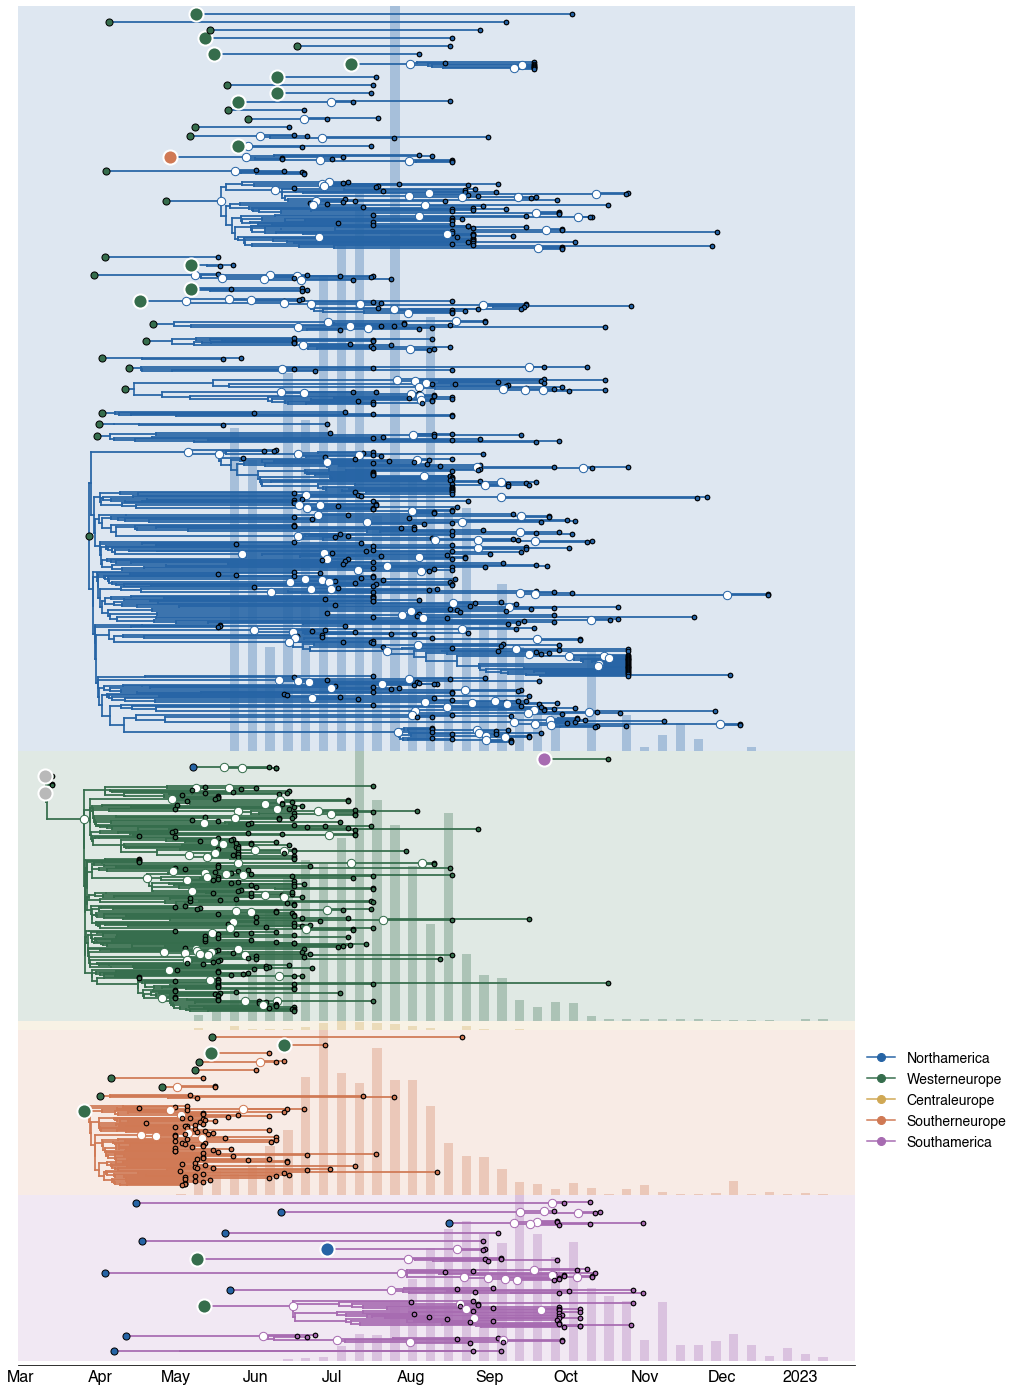

In [20]:
exploded_tree_output_file_name4 = "../figures/foo.png"

foo_plot_exploded_tree_with_cases(subtype_trees2, exploded_tree_output_file_name4,15,25, "region")  # dotted lines, no case counts


In [23]:
colors = {"Canada":"#133253",
          "United States of America":"#2664A5",
        
          
          # greens
          "United Kingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }

uncertainty_color = "#B9B9B9"

division_order = ["Canada",
"United States of America",
"United Kingdom",
"Germany",
"Switzerland",
"Austria",
"France",
"Belgium",
#"Netherlands",
"Slovakia",
"Slovenia",
"Italy",
"Portugal",
"Spain",
"Colombia",
"Peru"
#"Finland"
                
] 

In [30]:
division_order


['Austria',
 'Belgium',
 'Canada',
 'Colombia',
 'France',
 'Germany',
 'Italy',
 'Peru',
 'Portugal',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Switzerland',
 'United Kingdom',
 'United States of America']

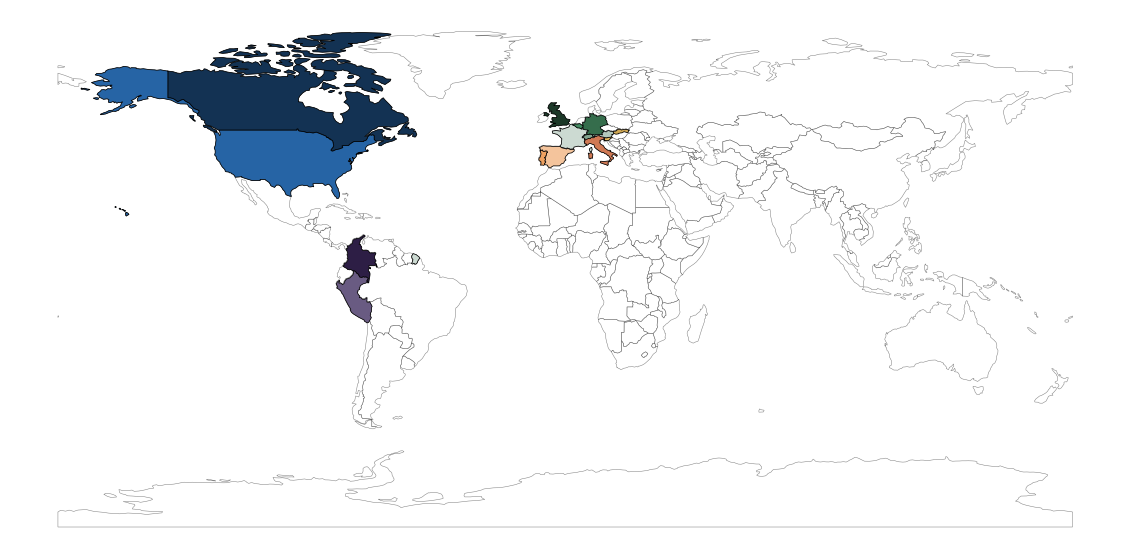

In [57]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.5, color="white", edgecolor="black", linewidth=0.5, figsize=(20,18))

for country in division_order: 
    world[world.name == country].plot(color=colors[country],
                                      ax=ax, edgecolor="black",
                                      linewidth=0.75)
    
ax.set_axis_off()
plt.savefig('map_wide.png')
plt.show() 

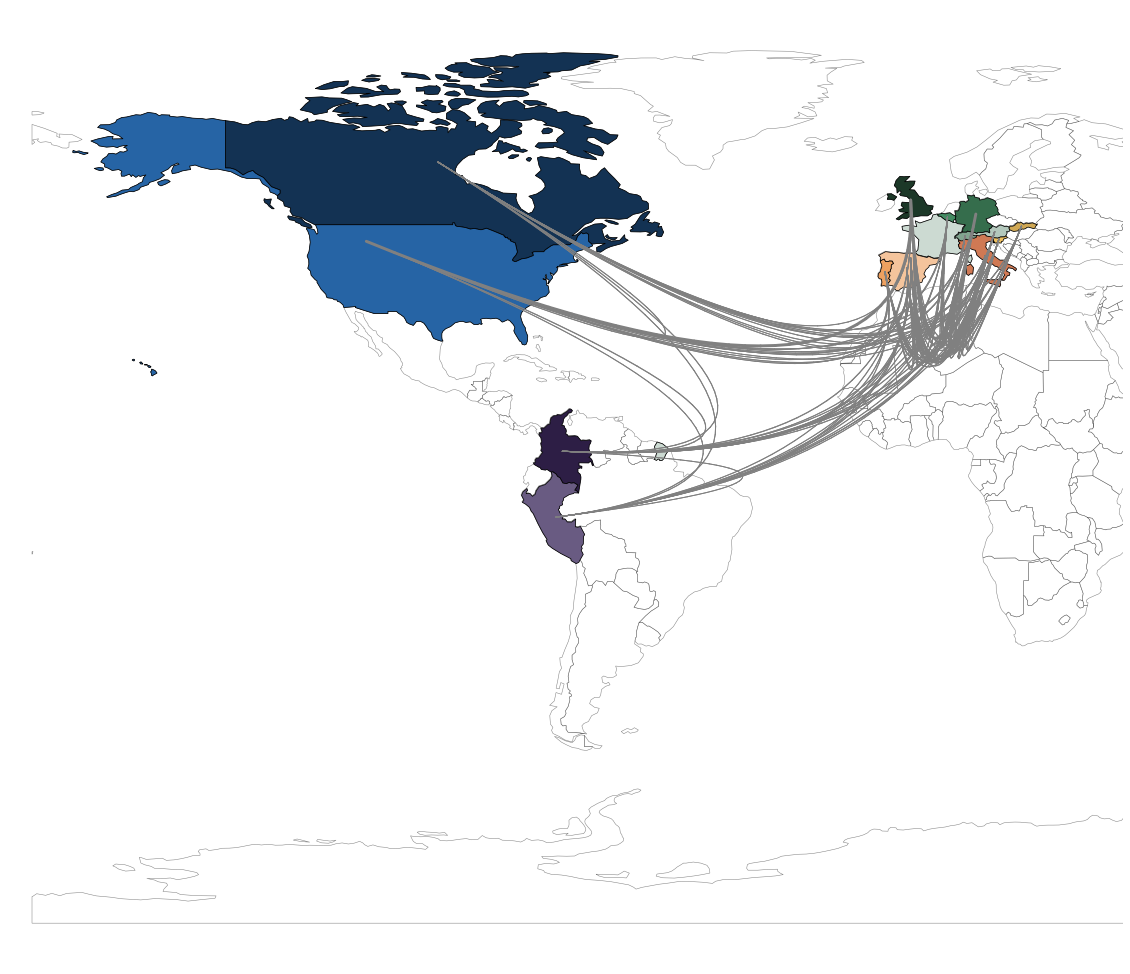

In [27]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.5, color="white", edgecolor="black", linewidth=0.5, figsize=(20,18))

for country in division_order: 
    world[world.name == country].plot(color=colors[country],
                                      ax=ax, edgecolor="black",
                                      linewidth=0.75)

root_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_country_masked_skygrid.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))


for headers in rootHeights.keys():
    if "country.rates" in headers:
        direction_mean = 0
        origin = headers.split(".")[2] 
        destination = headers.split(".")[3] 
        if origin == "UnitedKingdom":
            origin = "United Kingdom"
        if origin == "USA":
            origin = "United States of America"
        if destination == "UnitedKingdom":
            destination = "United Kingdom"
        if destination == "USA":
            destination = "United States of America"
        oriX,oriY=country_centroids[["lat", "long"]][country_centroids["name"] == origin].to_numpy()[0]
        desX,desY=country_centroids[["lat", "long"]][country_centroids["name"] == destination].to_numpy()[0]
        direction_mean = np.mean(rootHeights[headers])

        #destinationXs.append(desX)
        #destinationYs.append(desY)


        #print normalized_height,normalized_parent_height
        ## define Bezier curve
        distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2))


        ## get Bezier line coordinates
        curve=Bezier([(oriX,oriY),0.3,(desX,desY)],0.0,1.0,num=40)

        #midpoint=np.mean([normalized_parent_height,normalized_height])

        ## iterate through Bezier curve coordinates, alter colour according to height
        for i in range(len(curve)-1):
            x1,y1=curve[i]
            x2,y2=curve[i+1]
            frac=(i/float(len(curve)))

            ax.plot([x1,x2],[y1,y2],lw= direction_mean,color="gray",
                     solid_capstyle='round')
            #ax.plot([x1,x2],[y1,y2],lw=6+4*frac,color='k', solid_capstyle='round')
ax.set_axis_off()
ax.set_xlim(-185, 40)

plt.savefig('map_wide.png')
plt.show() 

In [34]:
region_centroids = pd.read_csv("region_lat_log.csv")
country_centroids = pd.read_csv("countries_lat_long.csv")

In [35]:
region_centroids

,Unnamed: 0,region_coarse,lat,long
0,0,CentralEurope,17.222905,47.426067
1,1,NorthAmerica,-105.370909,53.587352
2,2,SouthAmerica,-73.734769,-2.632175
3,3,SouthernEurope,0.156001,40.911296
4,4,WesternEurope,5.222324,48.761221


In [1011]:
foo1, foo2 = country_centroids[["lat", "long"]][country_centroids["name"] == "Canada"].to_numpy()[0]

In [36]:
def Bezier(points,start,end,num=10):
    """Build Bezier curve from points.
    """
    N = len(points)
    t = np.linspace(start, end, num)
    curve = np.zeros((num, 2))
    for ii in range(N):
        curve += np.outer(Bernstein(N - 1, ii)(t), points[ii])
        
    return curve

In [37]:
def Bernstein(n, k):
    """Bernstein polynomial.
    """
    coeff = binom(n, k)

    def _bpoly(x):
        return coeff * x ** k * (1 - x) ** (n - k)

    return _bpoly

In [33]:
root_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_region_unmasked.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))

 


In [34]:
for headers in rootHeights.keys():
    #if "country.rates" in headers:
    print(headers)
    #origin = headers.split(".")[2] 
    #destination = headers.split(".")[3] 

joint
prior
likelihood
treeModel.rootHeight
age(root)
treeLength
skyline.popSize1
skyline.popSize2
skyline.popSize3
skyline.popSize4
skyline.popSize5
skyline.popSize6
skyline.popSize7
skyline.popSize8
skyline.popSize9
skyline.popSize10
skyline.groupSize1
skyline.groupSize2
skyline.groupSize3
skyline.groupSize4
skyline.groupSize5
skyline.groupSize6
skyline.groupSize7
skyline.groupSize8
skyline.groupSize9
skyline.groupSize10
gtr.rates.rateAC
gtr.rates.rateAG
gtr.rates.rateAT
gtr.rates.rateCG
gtr.rates.rateCT
gtr.rates.rateGT
frequencies1
frequencies2
frequencies3
frequencies4
alpha
pInv
default.clock.rate
region.clock.rate
default.meanRate
region.meanRate
region.rates.CentralEurope.NorthAmerica
region.rates.CentralEurope.SouthAmerica
region.rates.CentralEurope.SouthernEurope
region.rates.CentralEurope.WesternEurope
region.rates.NorthAmerica.SouthAmerica
region.rates.NorthAmerica.SouthernEurope
region.rates.NorthAmerica.WesternEurope
region.rates.SouthAmerica.SouthernEurope
region.rates.S

In [16]:
division_order = ["Canada",
"United States of America",
"United Kingdom",
"Germany",
"Switzerland",
"Austria",
"France",
"Belgium",
#"Netherlands",
"Slovakia",
"Slovenia",
"Italy",
"Portugal",
"Spain",
"Colombia",
"Peru"
#"Finland"
                
] 



#region = {('Canada','USA'):'North America',
#          'Finland':'Northern Europe',
#          ('Austria','Germany','Switzerland','UnitedKingdom','France','Belgium','Netherlands'):'Western Europe', 
#          ('Slovakia','Slovenia'):'Central/Eastern Europe',
#          ('Italy','Portugal','Spain'):'Southern Europe',
#          ('Colombia','Peru'):'South America'}




         # blues
colors = {"Canada":"#133253",
          "United States of America":"#2664A5",
        
          
          # greens
          "United Kingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }

uncertainty_color = "#B9B9B9"

In [32]:
colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

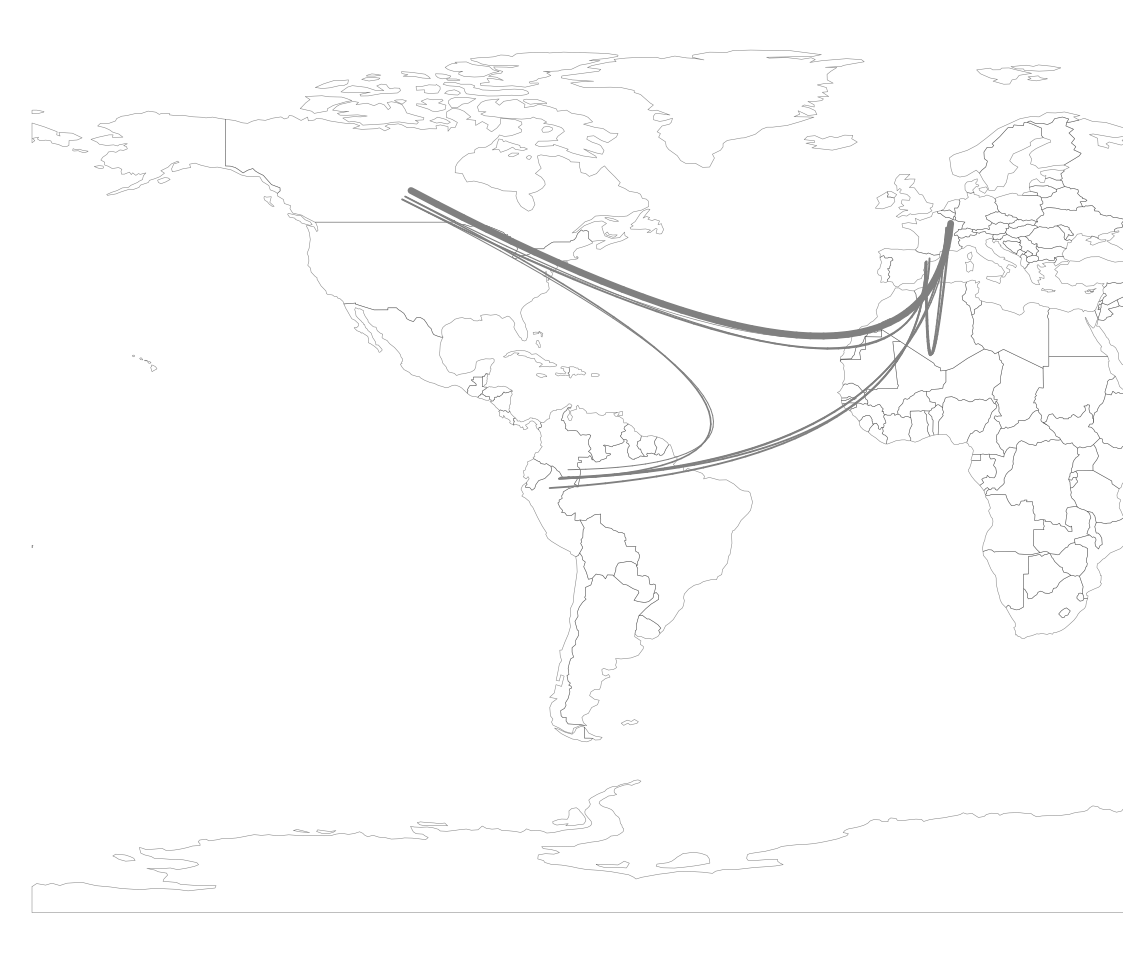

In [38]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.5, color="white", edgecolor="black", linewidth=0.5, figsize=(20,18))

# for country in division_order: 
#     world[world.name == country].plot(color=colors[country],
#                                       ax=ax, edgecolor="black",
#                                       linewidth=0.75)

root_path = "/Users/mparedes/Desktop/mpox_rhino/fixed_region_prev_sub_500_masked.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))


for headers in rootHeights.keys():
    if "region.rates" in headers:
        direction_mean = 0
        origin = headers.split(".")[2] 
        destination = headers.split(".")[3] 

        oriX,oriY=region_centroids[["lat", "long"]][region_centroids["region_coarse"] == origin].to_numpy()[0]
        desX,desY=region_centroids[["lat", "long"]][region_centroids["region_coarse"] == destination].to_numpy()[0]
        direction_mean = np.mean(rootHeights[headers])

        #destinationXs.append(desX)
        #destinationYs.append(desY)


        #print normalized_height,normalized_parent_height
        ## define Bezier curve
        distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2))
        jitter=np.random.uniform(-2,2)


        ## get Bezier line coordinates
        curve=Bezier([(oriX,oriY),0.3,(desX+jitter,desY+jitter)],0.0,1.0,num=40)

        #midpoint=np.mean([normalized_parent_height,normalized_height])

        ## iterate through Bezier curve coordinates, alter colour according to height
        for i in range(len(curve)-1):
            x1,y1=curve[i]
            x2,y2=curve[i+1]
            frac=(i/float(len(curve)))

            ax.plot([x1,x2],[y1,y2],lw=2*direction_mean,color="gray",
                     solid_capstyle='round')
            #ax.plot([x1,x2],[y1,y2],lw=6+4*frac,color='k', solid_capstyle='round')
ax.set_axis_off()
ax.set_xlim(-185, 40)

#plt.savefig('map_wide.png')
plt.show() 

In [42]:
for headers in rootHeights.keys():
    print(headers, np.mean(rootHeights[headers]))

joint -259403.55251745007
prior -2963.075665665701
likelihood -256440.47685178436
treeModel.rootHeight 0.7928736046733406
age(root) 2022.2126058473814
treeLength 46.558947749820014
skyline.popSize1 8.016376454713807
skyline.popSize2 12.78447279019987
skyline.popSize3 12.448389391115361
skyline.popSize4 8.364299908638442
skyline.popSize5 5.394384307927606
skyline.popSize6 3.0510239798212475
skyline.popSize7 1.465231395692884
skyline.popSize8 0.5808967315475342
skyline.popSize9 0.14689229662679554
skyline.popSize10 0.016048056441925966
skyline.groupSize1 40.03935040599625
skyline.groupSize2 40.97938788257339
skyline.groupSize3 50.30106183635228
skyline.groupSize4 36.70643347907558
skyline.groupSize5 36.10930668332292
skyline.groupSize6 20.950655840099937
skyline.groupSize7 22.834478450968145
skyline.groupSize8 23.022485946283574
skyline.groupSize9 14.457214241099313
skyline.groupSize10 12.599625234228608
gtr.rates.rateAC 0.12957419142778373
gtr.rates.rateAG 2.7066862084937737
gtr.rates.r